In [1]:
import os
import re

import sys
import pyodbc

import pandas as pd
pd.set_option('max_columns', 1000)
#pd.options.display.max_colwidth = 100

import sklearn
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

import numpy as np

import dask.dataframe as dd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import altair as alt
from altair.expr import datum
alt.renderers.enable('default')
from altair_widgets import interact_with

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.figure_factory as ff

from datetime import datetime
from dateutil.relativedelta import relativedelta
import math
from collections import Counter

import gc
from tqdm import tqdm

import multiprocessing as mp
from multiprocessing import Pool

In [2]:
# paths to files
STARK_DATA_PATH = '/data_hdd/dataset/stark/2018'
STARK_DATA_EXPLORATION_PATH = '/data_hdd/dataset/stark/exploration_2019'
START_DATA_EVENTS_PATH = '/home/biclast/notebooks/anton/elka/sql_queries'
FIRST_DAY_DATA = '/home/biclast/notebooks/anton/elka/sql_queries/all_days'

In [3]:
# calculate percentage of missing data
def missing_data(data):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
    return pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

# calculate percentage of missing data from dask dataframe
def missing_data_dask(data):
    total = data.isnull().sum().compute().sort_values(ascending = False)
    percent = (data.isnull().compute().sum()/data.isnull().compute().count()*100).sort_values(ascending = False)
    return pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

In [4]:
# Label encoding
def label_encoding(df, col):
    return {v: i for i, v in enumerate(set(df[col]))}

In [5]:
df_X_all = pd.read_csv(os.path.join(STARK_DATA_EXPLORATION_PATH, 'elka2019_ok_all_days_data_for_clustering.csv'),sep=',')

In [6]:
df_X_all.head()

user_id  is_old  sex  friends_count  \
0        1       1    1             21   
1        2       1    1            122   
2        3       1    1             35   
3        4       1    1             10   
4        5       1    1             13   

   time_from_install_to_first_session_sec  whole_time_sec  playtime_sec  \
0                                  256157         6570534        383515   
1                                  772578         6213853        156633   
2                                  772652         6209056       2273817   
3                                  349723         6624927        469292   
4                                  819116          432194          2845   

   whole_session_number  avg_session_duration_sec  avg_session_gap_sec  \
0                   183               2095.710383         33994.609890   
1                   533                293.870544         11385.751880   
2                   395               5756.498734          9987.916244   
3                   151               3107.894040         41037.566667   
4                     9                316.111111         53668.625000   

    gross  payment_count  level_min  level_max  level_delta  \
0     0.0              0          1        222          221   
1   844.0              6          1        629          628   
2  1112.0              8          1        584          583   
3     0.0              0          2        399          397   
4     0.0              0          9         59           50   

   level_increase_rate  current_level  is_paid  toys_release_count  \
0             0.000576            222        0                  74   
1             0.004009            629        1                 684   
2             0.000256            588        1                 320   
3             0.000846            399        0                  84   
4             0.017575             65        0                   3   

   toy_purchase_count  gift_count  chest_open_count  is_own_count  \
0                  19           0               385            60   
1                  59           0              1144           194   
2                  80           1              1135           147   
3                  20           0               344            80   
4                   2           0                25             6   

   arcleft_amount_sum  arcright_amount_sum  carousel_amount_sum  \
0                 220                  220                52706   
1                 220                    0               199300   
2                 330                  440               205566   
3                 110                  110                99914   
4                   0                    0                 4400   

   deerhouse_amount_sum  fatherfrost_amount_sum  santahouse_amount_sum  \
0                 27664                    4442                  47231   
1                353513                  205852                 227363   
2                197131                  144404                 225741   
3                103449                   38000                 118110   
4                  1000                    3000                   3129   

   snowmaiden_amount_sum  spruce_amount_sum  arcleft_count  arcright_count  \
0                  43000              49948              5               3   
1                 302222             301373              2               0   
2                 298053             291992              6               4   
3                 155341             147370              2               2   
4                      0                126              0               0   

   carousel_count  deerhouse_count  fatherfrost_count  santahouse_count  \
0              94               73                 13                91   
1              58              137                108                69   
2             152              111                 69               153   
3              54     

In [10]:
df_X_day1 = pd.read_csv(os.path.join(STARK_DATA_EXPLORATION_PATH, 'elka2019_ok_first_day_data_for_clustering.csv'),sep=',')

In [12]:
df_X_day1.head()

user_id  is_old  sex  friends_count  \
0        1       1    1             21   
1        2       1    1            122   
2        3       1    1             35   
3        4       1    1             10   
4        5       1    1             13   

   time_from_install_to_first_session_sec  whole_time_day1  playtime_day1  \
0                                  256157            14386          14386   
1                                  772578            92129          18874   
2                                  772652            87405          47915   
3                                  349723              600            600   
4                                  819116            26901           1208   

   session_number_day1  avg_session_duration_sec_day1  \
0                    1                   14386.000000   
1                   22                     857.909091   
2                   70                     684.500000   
3                    1                     600.000000   
4                    5                     241.600000   

   avg_session_gap_sec_day1  gross_day1  payment_count_day1  level_min_day1  \
0                  0.000000         0.0                   0               0   
1               3488.333333         0.0                   0               1   
2                572.318841         0.0                   0               1   
3                  0.000000         0.0                   0               0   
4               6423.250000         0.0                   0               9   

   level_max_day1  level_delta_day1  level_increase_rate_day1  is_paid_day1  \
0               0                 0                  0.000000             0   
1              35                34                  0.001801             0   
2              29                28                  0.000584             0   
3               0                 0                  0.000000             0   
4              16                 7                  0.005795             0   

   toys_release_count_day1  toy_purchase_count_day1  gift_count_day1  \
0                        4                        0                0   
1                        1                        1                0   
2                        2                        1                0   
3                        0                        0                0   
4                        1                        1                0   

   chest_open_count_day1  is_own_count_day1  arcleft_amount_sum_day1  \
0                      7                  1                        0   
1                     14                  6                      220   
2                     17                  8                      110   
3                      1                  1                        0   
4                     11                  4                        0   

   arcright_amount_sum_day1  carousel_amount_sum_day1  \
0                         0                       900   
1                         0                      3800   
2                       110                       400   
3                         0                         0   
4                         0                       400   

   deerhouse_amount_sum_day1  fatherfrost_amount_sum_day1  \
0                        533                            0   
1                       1000                            0   
2                       1000                           24   
3                          0                            0   
4                          0                            0   

   santahouse_amount_sum_day1  snowmaiden_amount_sum_day1  \
0                         305                          34   
1                        2220                        5000   
2                        1919                        2500   
3                           0                           0   
4                         930                           0   

   spruce_amount_sum_day1  arcleft_count_day1  arcr

In [8]:
df_X_all['top_window_page'] = df_X_all.top_window_page.map(label_encoding(df_X_all,'top_window_page'))

In [9]:
df_X_all.to_csv(os.path.join(STARK_DATA_EXPLORATION_PATH,'elka2019_ok_all_days_data_for_clustering.csv'),sep=',',index=False)

# Все данные вместе с ивентами

## Расчет инерции для оценки возможного числа кластеров

CPU times: user 1h 6min 31s, sys: 2min 53s, total: 1h 9min 24s
Wall time: 24min 2s


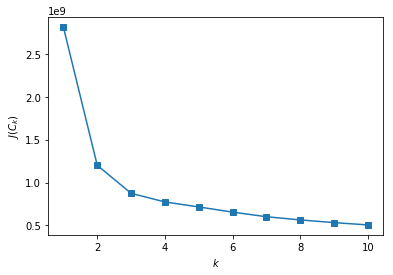

In [15]:
%%time

from sklearn.cluster import KMeans

#n_comp = 16
class_range = 11
#X_prepca = PCA(n_components=n_comp).fit_transform(X)

inertia = []
for k in range(1, class_range):
    kmeans = KMeans(n_clusters=k, random_state=17, n_jobs=-1).fit(df_X_all.iloc[:,1:])
    inertia.append(np.sqrt(kmeans.inertia_))

plt.plot(range(1, class_range), inertia, marker='s');
plt.xlabel('$k$')
plt.ylabel('$J(C_k)$');

# Модель для разного числа кластеров

In [16]:
kmeans_3 = KMeans(n_clusters=3, random_state=17, n_jobs=-1).fit(df_X_all.iloc[:,1:])
kmeans_4 = KMeans(n_clusters=4, random_state=17, n_jobs=-1).fit(df_X_all.iloc[:,1:])
kmeans_5 = KMeans(n_clusters=5, random_state=17, n_jobs=-1).fit(df_X_all.iloc[:,1:])
kmeans_6 = KMeans(n_clusters=6, random_state=17, n_jobs=-1).fit(df_X_all.iloc[:,1:])

In [18]:
df_X_all['kmeans_3'] = kmeans_3.labels_
df_X_all['kmeans_4'] = kmeans_4.labels_
df_X_all['kmeans_5'] = kmeans_5.labels_
df_X_all['kmeans_6'] = kmeans_6.labels_

# Сопоставление с категориями, выделенными вручную

In [21]:
# Set categories by level
# 2 categories: 1 - 'random users', 2 - 'average users'

bins = [-np.inf, 100, 1000, np.inf]
labels = ['1 - random users', '2 - average users', '3 - top users']
df_X_all['level_cats'] = pd.cut(df_X_all['current_level'], bins=bins, labels=labels)

In [22]:
# Set categories by whole_wasted_hours data
# 4 categories: 'wh <= 1', '1 < wh <= 12', '12 < wh <= 24', 'wh > 24'

bins = [-np.inf, 1*3600, 12*3600, 24*3600, np.inf]
labels = ['wh <= 1', '1 < wh <= 12', '12 < wh <= 24', 'wh > 24']
df_X_all['wasted_hours_cats'] = pd.cut(df_X_all['whole_time_sec'], bins=bins, labels=labels)

In [48]:
df_X_all.head()

user_id  is_old  sex  friends_count  \
0        1       1    1             21   
1        2       1    1            122   
2        3       1    1             35   
3        4       1    1             10   
4        5       1    1             13   

   time_from_install_to_first_session_sec  whole_time_sec  playtime_sec  \
0                                  256157         6570534        383515   
1                                  772578         6213853        156633   
2                                  772652         6209056       2273817   
3                                  349723         6624927        469292   
4                                  819116          432194          2845   

   whole_session_number  avg_session_duration_sec  avg_session_gap_sec  \
0                   183               2095.710383         33994.609890   
1                   533                293.870544         11385.751880   
2                   395               5756.498734          9987.916244   
3                   151               3107.894040         41037.566667   
4                     9                316.111111         53668.625000   

    gross  payment_count  level_min  level_max  level_delta  \
0     0.0              0          1        222          221   
1   844.0              6          1        629          628   
2  1112.0              8          1        584          583   
3     0.0              0          2        399          397   
4     0.0              0          9         59           50   

   level_increase_rate  current_level  is_paid  toys_release_count  \
0             0.000576            222        0                  74   
1             0.004009            629        1                 684   
2             0.000256            588        1                 320   
3             0.000846            399        0                  84   
4             0.017575             65        0                   3   

   toy_purchase_count  gift_count  chest_open_count  is_own_count  \
0                  19           0               385            60   
1                  59           0              1144           194   
2                  80           1              1135           147   
3                  20           0               344            80   
4                   2           0                25             6   

   arcleft_amount_sum  arcright_amount_sum  carousel_amount_sum  \
0                 220                  220                52706   
1                 220                    0               199300   
2                 330                  440               205566   
3                 110                  110                99914   
4                   0                    0                 4400   

   deerhouse_amount_sum  fatherfrost_amount_sum  santahouse_amount_sum  \
0                 27664                    4442                  47231   
1                353513                  205852                 227363   
2                197131                  144404                 225741   
3                103449                   38000                 118110   
4                  1000                    3000                   3129   

   snowmaiden_amount_sum  spruce_amount_sum  arcleft_count  arcright_count  \
0                  43000              49948              5               3   
1                 302222             301373              2               0   
2                 298053             291992              6               4   
3                 155341             147370              2               2   
4                      0                126              0               0   

   carousel_count  deerhouse_count  fatherfrost_count  santahouse_count  \
0              94               73                 13                91   
1              58              137                108                69   
2             152              111                 69               153   
3              54     

In [53]:
df_X_all['leaving_day'] = (df_X_all.whole_time_sec/3600/24).astype('int') + 1

## Сопоставление с level_cats:

In [23]:
df_alt = df_X_all.groupby(['level_cats','kmeans_3']).user_id.count().reset_index()# .groupby('level_cats').user_id.transform(lambda x: x/x.sum())
df_alt['relative'] = df_alt.groupby('level_cats').user_id.transform(lambda x: x/x.sum()*100)

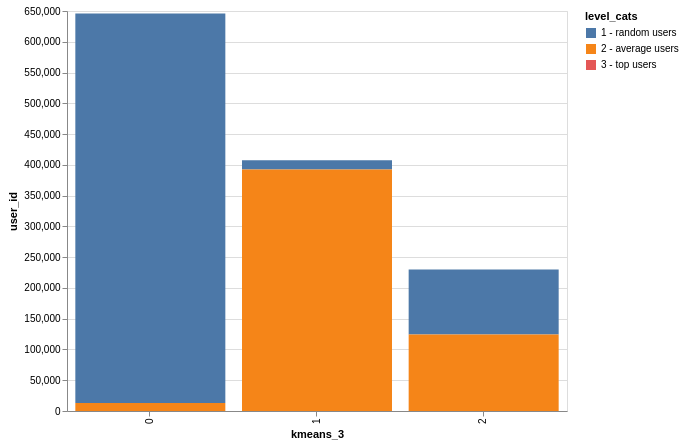

In [24]:
#df_alt = df_uniq_users.groupby(['level_cats','leaving_day']).avg_session_gap_hours.mean().reset_index()
alt.Chart(df_alt).mark_bar(stroke='transparent').encode(
    alt.X('kmeans_3:N', axis=alt.Axis(title='kmeans_3')),
    alt.Y('user_id', axis=alt.Axis(title='user_id', grid=True)),
    color=alt.Color('level_cats:N',title='level_cats'),
    tooltip=[alt.Tooltip('level_cats:N', title='level_cats'),
             alt.Tooltip('user_id:Q', title='count of users',format='.2e')]
).properties(
    width=500,
    height=400
)

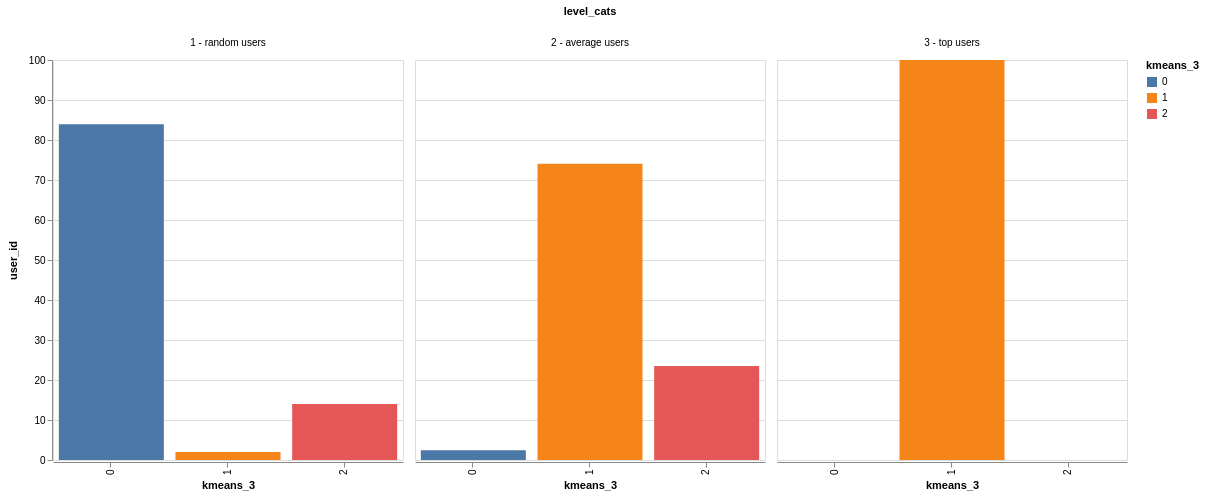

In [25]:
alt.Chart(df_alt).mark_bar(stroke='transparent').encode(
    alt.X('kmeans_3:N', axis=alt.Axis(title='kmeans_3')),
    alt.Y('relative', axis=alt.Axis(title='user_id', grid=True)),
    color=alt.Color('kmeans_3:N',title='kmeans_3'),
    column='level_cats',
    tooltip=[alt.Tooltip('level_cats:N', title='level_cats'),
             alt.Tooltip('user_id:Q', title='count of users',format='.2e')]
).properties(
    width=350,
    height=400
)

In [26]:
df_alt = df_X_all.groupby(['level_cats','kmeans_4']).user_id.count().reset_index()# .groupby('level_cats').user_id.transform(lambda x: x/x.sum())
df_alt['relative'] = df_alt.groupby('level_cats').user_id.transform(lambda x: x/x.sum()*100)

In [27]:
#df_alt = df_uniq_users.groupby(['level_cats','leaving_day']).avg_session_gap_hours.mean().reset_index()
alt.Chart(df_alt).mark_bar(stroke='transparent').encode(
    alt.X('kmeans_4:N', axis=alt.Axis(title='kmeans_4')),
    alt.Y('user_id', axis=alt.Axis(title='user_id', grid=True)),
    color=alt.Color('level_cats:N',title='level_cats'),
    tooltip=[alt.Tooltip('level_cats:N', title='level_cats'),
             alt.Tooltip('user_id:Q', title='count of users',format='.2e')]
).properties(
    width=500,
    height=400
)

In [28]:
alt.Chart(df_alt).mark_bar(stroke='transparent').encode(
    alt.X('kmeans_4:N', axis=alt.Axis(title='kmeans_4')),
    alt.Y('relative', axis=alt.Axis(title='user_id', grid=True)),
    color=alt.Color('kmeans_4:N',title='kmeans_4'),
    column='level_cats',
    tooltip=[alt.Tooltip('level_cats:N', title='level_cats'),
             alt.Tooltip('user_id:Q', title='count of users',format='.2e')]
).properties(
    width=350,
    height=400
)

In [29]:
df_alt = df_X_all.groupby(['level_cats','kmeans_5']).user_id.count().reset_index()# .groupby('level_cats').user_id.transform(lambda x: x/x.sum())
df_alt['relative'] = df_alt.groupby('level_cats').user_id.transform(lambda x: x/x.sum()*100)

In [30]:
#df_alt = df_uniq_users.groupby(['level_cats','leaving_day']).avg_session_gap_hours.mean().reset_index()
alt.Chart(df_alt).mark_bar(stroke='transparent').encode(
    alt.X('kmeans_5:N', axis=alt.Axis(title='kmeans_5')),
    alt.Y('user_id', axis=alt.Axis(title='user_id', grid=True)),
    color=alt.Color('level_cats:N',title='level_cats'),
    tooltip=[alt.Tooltip('level_cats:N', title='level_cats'),
             alt.Tooltip('user_id:Q', title='count of users',format='.2e')]
).properties(
    width=500,
    height=400
)

In [31]:
alt.Chart(df_alt).mark_bar(stroke='transparent').encode(
    alt.X('kmeans_5:N', axis=alt.Axis(title='kmeans_5')),
    alt.Y('relative', axis=alt.Axis(title='user_id', grid=True)),
    color=alt.Color('kmeans_5:N',title='kmeans_5'),
    column='level_cats',
    tooltip=[alt.Tooltip('level_cats:N', title='level_cats'),
             alt.Tooltip('user_id:Q', title='count of users',format='.2e')]
).properties(
    width=350,
    height=400
)

In [32]:
df_alt = df_X_all.groupby(['level_cats','kmeans_6']).user_id.count().reset_index()# .groupby('level_cats').user_id.transform(lambda x: x/x.sum())
df_alt['relative'] = df_alt.groupby('level_cats').user_id.transform(lambda x: x/x.sum()*100)

In [33]:
#df_alt = df_uniq_users.groupby(['level_cats','leaving_day']).avg_session_gap_hours.mean().reset_index()
alt.Chart(df_alt).mark_bar(stroke='transparent').encode(
    alt.X('kmeans_6:N', axis=alt.Axis(title='kmeans_6')),
    alt.Y('user_id', axis=alt.Axis(title='user_id', grid=True)),
    color=alt.Color('level_cats:N',title='level_cats'),
    tooltip=[alt.Tooltip('level_cats:N', title='level_cats'),
             alt.Tooltip('user_id:Q', title='count of users',format='.2e')]
).properties(
    width=500,
    height=400
)

In [34]:
alt.Chart(df_alt).mark_bar(stroke='transparent').encode(
    alt.X('kmeans_6:N', axis=alt.Axis(title='kmeans_6')),
    alt.Y('relative', axis=alt.Axis(title='user_id', grid=True)),
    color=alt.Color('kmeans_6:N',title='kmeans_6'),
    column='level_cats',
    tooltip=[alt.Tooltip('level_cats:N', title='level_cats'),
             alt.Tooltip('user_id:Q', title='count of users',format='.2e')]
).properties(
    width=350,
    height=400
)

## Сопоставление с is_old:

In [36]:
df_alt = df_X_all.groupby(['is_old','kmeans_3']).user_id.count().reset_index()# .groupby('level_cats').user_id.transform(lambda x: x/x.sum())
df_alt['relative'] = df_alt.groupby('is_old').user_id.transform(lambda x: x/x.sum()*100)

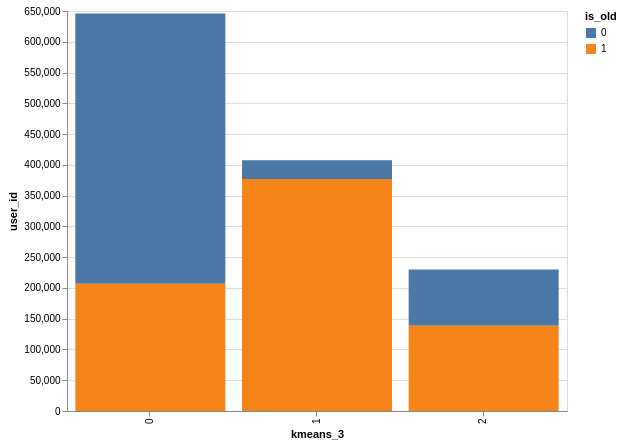

In [37]:
#df_alt = df_uniq_users.groupby(['level_cats','leaving_day']).avg_session_gap_hours.mean().reset_index()
alt.Chart(df_alt).mark_bar(stroke='transparent').encode(
    alt.X('kmeans_3:N', axis=alt.Axis(title='kmeans_3')),
    alt.Y('user_id', axis=alt.Axis(title='user_id', grid=True)),
    color=alt.Color('is_old:N',title='is_old'),
    tooltip=[alt.Tooltip('is_old:Q', title='is old'),
             alt.Tooltip('user_id:Q', title='count of users',format='.2e')]
).properties(
    width=500,
    height=400
)

In [38]:
alt.Chart(df_alt).mark_bar(stroke='transparent').encode(
    alt.X('kmeans_3:N', axis=alt.Axis(title='kmeans_3')),
    alt.Y('relative', axis=alt.Axis(title='user_id', grid=True)),
    color=alt.Color('kmeans_3:N',title='kmeans_3'),
    column='is_old',
    tooltip=[alt.Tooltip('is_old:Q', title='is old'),
             alt.Tooltip('user_id:Q', title='count of users',format='.2e')]
).properties(
    width=350,
    height=400
)

In [39]:
df_alt = df_X_all.groupby(['is_old','kmeans_4']).user_id.count().reset_index()# .groupby('level_cats').user_id.transform(lambda x: x/x.sum())
df_alt['relative'] = df_alt.groupby('is_old').user_id.transform(lambda x: x/x.sum()*100)

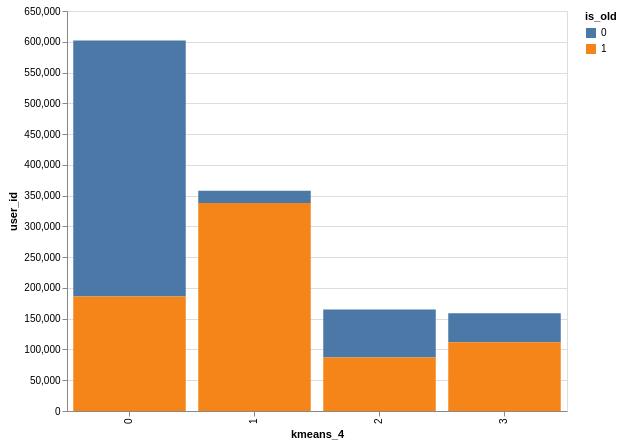

In [40]:
#df_alt = df_uniq_users.groupby(['level_cats','leaving_day']).avg_session_gap_hours.mean().reset_index()
alt.Chart(df_alt).mark_bar(stroke='transparent').encode(
    alt.X('kmeans_4:N', axis=alt.Axis(title='kmeans_4')),
    alt.Y('user_id', axis=alt.Axis(title='user_id', grid=True)),
    color=alt.Color('is_old:N',title='is_old'),
    tooltip=[alt.Tooltip('is_old:Q', title='is old'),
             alt.Tooltip('user_id:Q', title='count of users',format='.2e')]
).properties(
    width=500,
    height=400
)

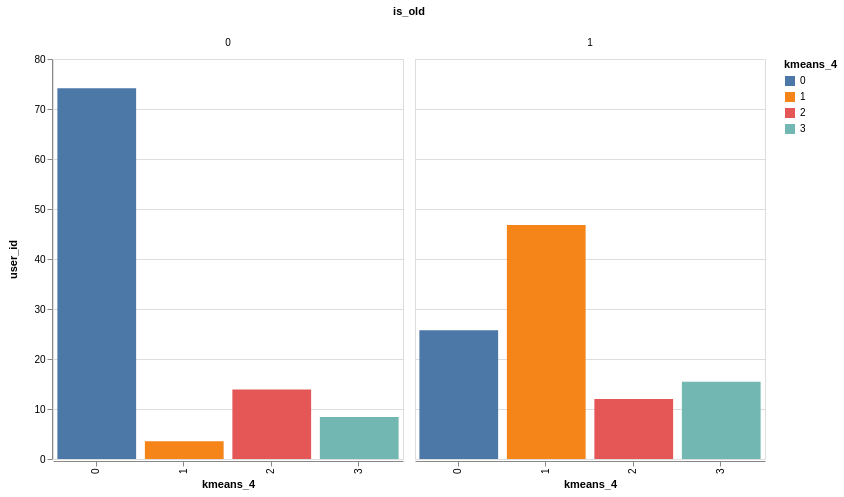

In [41]:
alt.Chart(df_alt).mark_bar(stroke='transparent').encode(
    alt.X('kmeans_4:N', axis=alt.Axis(title='kmeans_4')),
    alt.Y('relative', axis=alt.Axis(title='user_id', grid=True)),
    color=alt.Color('kmeans_4:N',title='kmeans_4'),
    column='is_old',
    tooltip=[alt.Tooltip('is_old:Q', title='is old'),
             alt.Tooltip('user_id:Q', title='count of users',format='.2e')]
).properties(
    width=350,
    height=400
)

In [42]:
df_alt = df_X_all.groupby(['is_old','kmeans_5']).user_id.count().reset_index()# .groupby('level_cats').user_id.transform(lambda x: x/x.sum())
df_alt['relative'] = df_alt.groupby('is_old').user_id.transform(lambda x: x/x.sum()*100)

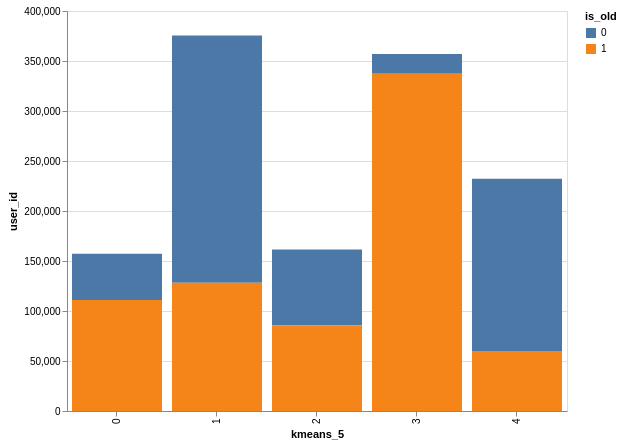

In [43]:
#df_alt = df_uniq_users.groupby(['level_cats','leaving_day']).avg_session_gap_hours.mean().reset_index()
alt.Chart(df_alt).mark_bar(stroke='transparent').encode(
    alt.X('kmeans_5:N', axis=alt.Axis(title='kmeans_5')),
    alt.Y('user_id', axis=alt.Axis(title='user_id', grid=True)),
    color=alt.Color('is_old:N',title='is_old'),
    tooltip=[alt.Tooltip('is_old:Q', title='is old'),
             alt.Tooltip('user_id:Q', title='count of users',format='.2e')]
).properties(
    width=500,
    height=400
)

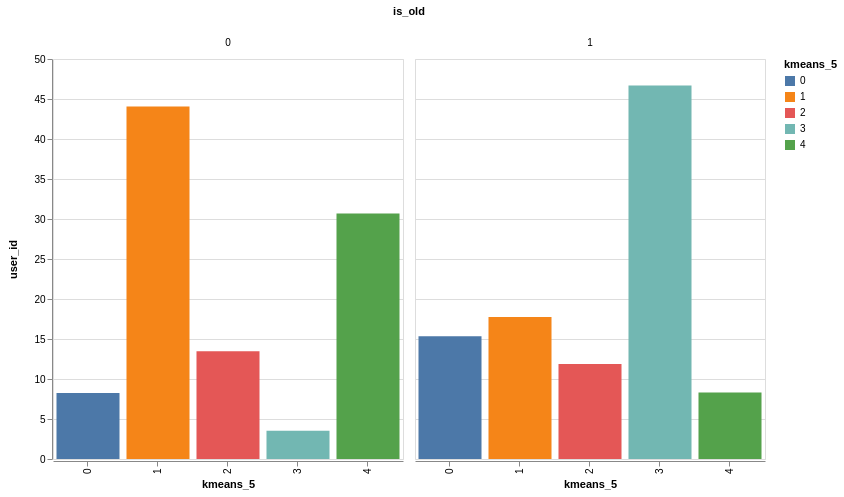

In [44]:
alt.Chart(df_alt).mark_bar(stroke='transparent').encode(
    alt.X('kmeans_5:N', axis=alt.Axis(title='kmeans_5')),
    alt.Y('relative', axis=alt.Axis(title='user_id', grid=True)),
    color=alt.Color('kmeans_5:N',title='kmeans_5'),
    column='is_old',
    tooltip=[alt.Tooltip('is_old:Q', title='is old'),
             alt.Tooltip('user_id:Q', title='count of users',format='.2e')]
).properties(
    width=350,
    height=400
)

In [45]:
df_alt = df_X_all.groupby(['is_old','kmeans_6']).user_id.count().reset_index()# .groupby('level_cats').user_id.transform(lambda x: x/x.sum())
df_alt['relative'] = df_alt.groupby('is_old').user_id.transform(lambda x: x/x.sum()*100)

In [46]:
#df_alt = df_uniq_users.groupby(['level_cats','leaving_day']).avg_session_gap_hours.mean().reset_index()
alt.Chart(df_alt).mark_bar(stroke='transparent').encode(
    alt.X('kmeans_6:N', axis=alt.Axis(title='kmeans_6')),
    alt.Y('user_id', axis=alt.Axis(title='user_id', grid=True)),
    color=alt.Color('is_old:N',title='is_old'),
    tooltip=[alt.Tooltip('is_old:Q', title='is old'),
             alt.Tooltip('user_id:Q', title='count of users',format='.2e')]
).properties(
    width=500,
    height=400
)

In [47]:
alt.Chart(df_alt).mark_bar(stroke='transparent').encode(
    alt.X('kmeans_6:N', axis=alt.Axis(title='kmeans_6')),
    alt.Y('relative', axis=alt.Axis(title='user_id', grid=True)),
    color=alt.Color('kmeans_6:N',title='kmeans_6'),
    column='is_old',
    tooltip=[alt.Tooltip('is_old:Q', title='is old'),
             alt.Tooltip('user_id:Q', title='count of users',format='.2e')]
).properties(
    width=350,
    height=400
)

## Сопоставление с leaving_day:

In [55]:
df_alt = df_X_all.groupby(['leaving_day','kmeans_3']).user_id.count().reset_index()# .groupby('level_cats').user_id.transform(lambda x: x/x.sum())
df_alt['relative'] = df_alt.groupby('leaving_day').user_id.transform(lambda x: x/x.sum()*100)

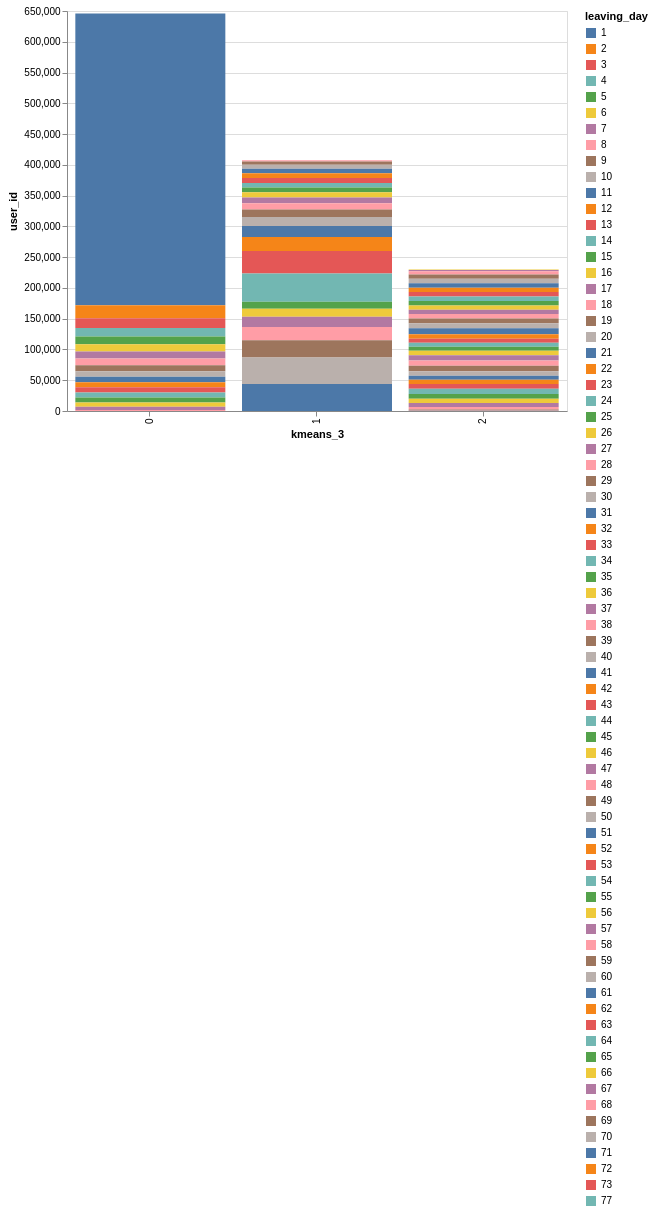

In [56]:
#df_alt = df_uniq_users.groupby(['level_cats','leaving_day']).avg_session_gap_hours.mean().reset_index()
alt.Chart(df_alt).mark_bar(stroke='transparent').encode(
    alt.X('kmeans_3:N', axis=alt.Axis(title='kmeans_3')),
    alt.Y('user_id', axis=alt.Axis(title='user_id', grid=True)),
    color=alt.Color('leaving_day:N',title='leaving_day'),
    tooltip=[alt.Tooltip('leaving_day:Q', title='leaving day'),
             alt.Tooltip('user_id:Q', title='count of users',format='.2e')]
).properties(
    width=500,
    height=400
)

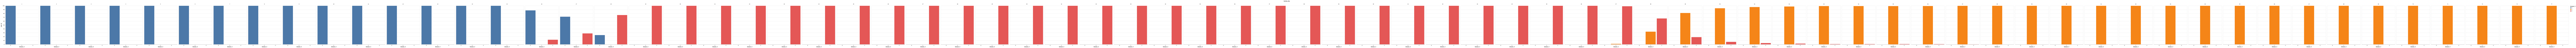

In [58]:
alt.Chart(df_alt).mark_bar(stroke='transparent').encode(
    alt.X('kmeans_3:N', axis=alt.Axis(title='kmeans_3')),
    alt.Y('relative', axis=alt.Axis(title='user_id', grid=True)),
    color=alt.Color('kmeans_3:N',title='kmeans_3'),
    column='leaving_day',
    tooltip=[alt.Tooltip('leaving_day:Q', title='leaving day'),
             alt.Tooltip('user_id:Q', title='count of users',format='.2e')]
).properties(
    width=350,
    height=400
)

In [59]:
df_alt = df_X_all.groupby(['leaving_day','kmeans_4']).user_id.count().reset_index()# .groupby('level_cats').user_id.transform(lambda x: x/x.sum())
df_alt['relative'] = df_alt.groupby('leaving_day').user_id.transform(lambda x: x/x.sum()*100)

In [60]:
#df_alt = df_uniq_users.groupby(['level_cats','leaving_day']).avg_session_gap_hours.mean().reset_index()
alt.Chart(df_alt).mark_bar(stroke='transparent').encode(
    alt.X('kmeans_4:N', axis=alt.Axis(title='kmeans_4')),
    alt.Y('user_id', axis=alt.Axis(title='user_id', grid=True)),
    color=alt.Color('leaving_day:N',title='leaving_day'),
    tooltip=[alt.Tooltip('leaving_day:Q', title='leaving day'),
             alt.Tooltip('user_id:Q', title='count of users',format='.2e')]
).properties(
    width=500,
    height=400
)

In [61]:
alt.Chart(df_alt).mark_bar(stroke='transparent').encode(
    alt.X('kmeans_4:N', axis=alt.Axis(title='kmeans_4')),
    alt.Y('relative', axis=alt.Axis(title='user_id', grid=True)),
    color=alt.Color('kmeans_4:N',title='kmeans_4'),
    column='leaving_day',
    tooltip=[alt.Tooltip('leaving_day:Q', title='leaving day'),
             alt.Tooltip('user_id:Q', title='count of users',format='.2e')]
).properties(
    width=350,
    height=400
)

In [62]:
df_alt = df_X_all.groupby(['leaving_day','kmeans_5']).user_id.count().reset_index()# .groupby('level_cats').user_id.transform(lambda x: x/x.sum())
df_alt['relative'] = df_alt.groupby('leaving_day').user_id.transform(lambda x: x/x.sum()*100)

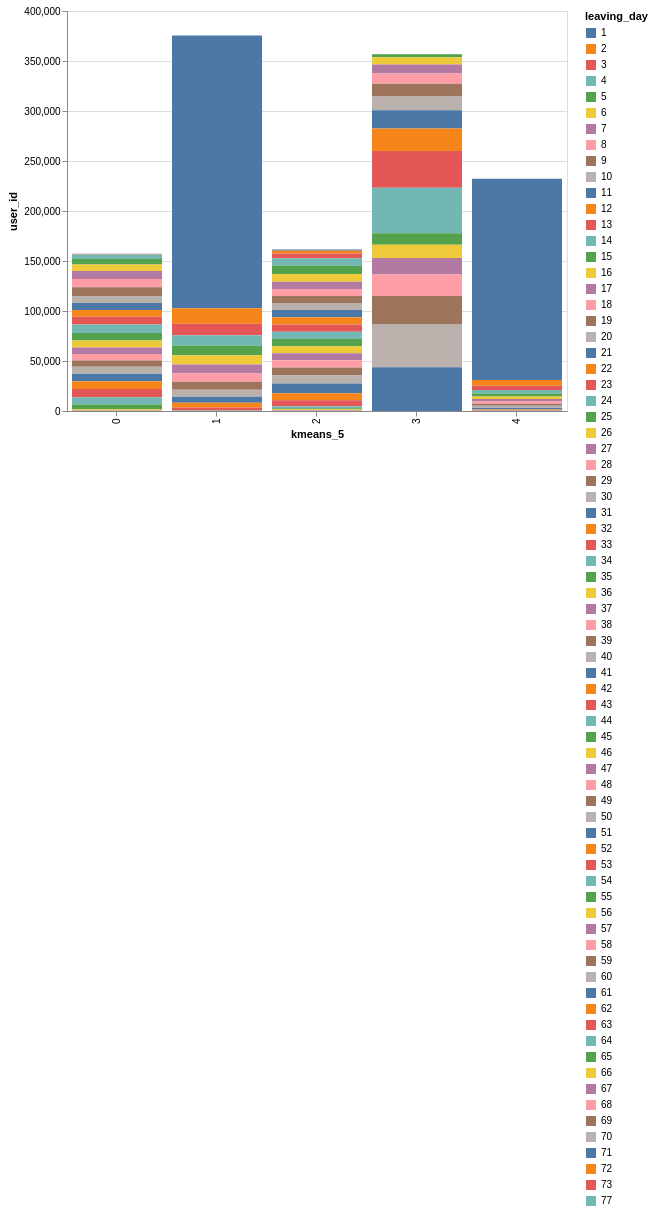

In [63]:
#df_alt = df_uniq_users.groupby(['level_cats','leaving_day']).avg_session_gap_hours.mean().reset_index()
alt.Chart(df_alt).mark_bar(stroke='transparent').encode(
    alt.X('kmeans_5:N', axis=alt.Axis(title='kmeans_5')),
    alt.Y('user_id', axis=alt.Axis(title='user_id', grid=True)),
    color=alt.Color('leaving_day:N',title='leaving_day'),
    tooltip=[alt.Tooltip('leaving_day:Q', title='leaving day'),
             alt.Tooltip('user_id:Q', title='count of users',format='.2e')]
).properties(
    width=500,
    height=400
)

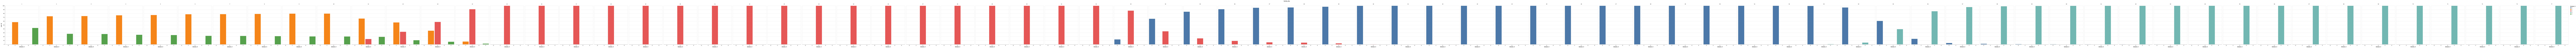

In [64]:
alt.Chart(df_alt).mark_bar(stroke='transparent').encode(
    alt.X('kmeans_5:N', axis=alt.Axis(title='kmeans_5')),
    alt.Y('relative', axis=alt.Axis(title='user_id', grid=True)),
    color=alt.Color('kmeans_5:N',title='kmeans_5'),
    column='leaving_day',
    tooltip=[alt.Tooltip('leaving_day:Q', title='leaving day'),
             alt.Tooltip('user_id:Q', title='count of users',format='.2e')]
).properties(
    width=350,
    height=400
)

## Сопоставление с is_paid:

In [182]:
df_alt = df_X_all.groupby(['is_paid','kmeans_3']).user_id.count().reset_index()# .groupby('level_cats').user_id.transform(lambda x: x/x.sum())
df_alt['relative'] = df_alt.groupby('is_paid').user_id.transform(lambda x: x/x.sum()*100)

In [184]:
#df_alt = df_uniq_users.groupby(['level_cats','leaving_day']).avg_session_gap_hours.mean().reset_index()
alt.Chart(df_alt).mark_bar(stroke='transparent').encode(
    alt.X('kmeans_3:N', axis=alt.Axis(title='kmeans_3')),
    alt.Y('user_id', axis=alt.Axis(title='number of users', grid=True)),
    color=alt.Color('is_paid:N',title='is_paid'),
    tooltip=[alt.Tooltip('is_paid:Q', title='is_paid'),
             alt.Tooltip('user_id:Q', title='count of users',format='.2e')]
).properties(
    width=200,
    height=200
)

In [186]:
alt.Chart(df_alt).mark_bar(stroke='transparent').encode(
    alt.X('kmeans_3:N', axis=alt.Axis(title='kmeans_3')),
    alt.Y('relative', axis=alt.Axis(title='percent of users', grid=True)),
    color=alt.Color('kmeans_3:N',title='kmeans_3'),
    column='is_paid',
    tooltip=[alt.Tooltip('is_paid:Q', title='is_paid'),
             alt.Tooltip('user_id:Q', title='count of users',format='.2e')]
).properties(
    width=100,
    height=150
)

In [71]:
df_alt = df_X_all.groupby(['is_paid','kmeans_4']).user_id.count().reset_index()# .groupby('level_cats').user_id.transform(lambda x: x/x.sum())
df_alt['relative'] = df_alt.groupby('is_paid').user_id.transform(lambda x: x/x.sum()*100)

In [72]:
#df_alt = df_uniq_users.groupby(['level_cats','leaving_day']).avg_session_gap_hours.mean().reset_index()
alt.Chart(df_alt).mark_bar(stroke='transparent').encode(
    alt.X('kmeans_4:N', axis=alt.Axis(title='kmeans_4')),
    alt.Y('user_id', axis=alt.Axis(title='user_id', grid=True)),
    color=alt.Color('is_paid:N',title='is_paid'),
    tooltip=[alt.Tooltip('is_paid:Q', title='is_paid'),
             alt.Tooltip('user_id:Q', title='count of users',format='.2e')]
).properties(
    width=500,
    height=400
)

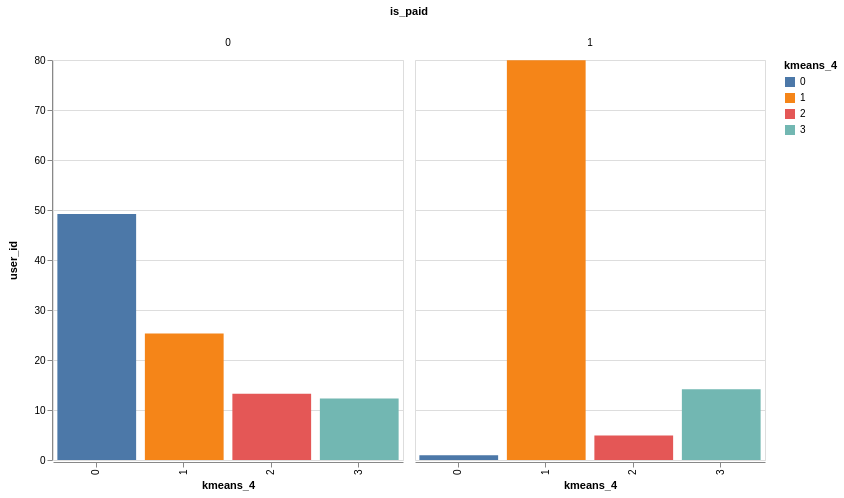

In [73]:
alt.Chart(df_alt).mark_bar(stroke='transparent').encode(
    alt.X('kmeans_4:N', axis=alt.Axis(title='kmeans_4')),
    alt.Y('relative', axis=alt.Axis(title='user_id', grid=True)),
    color=alt.Color('kmeans_4:N',title='kmeans_4'),
    column='is_paid',
    tooltip=[alt.Tooltip('is_paid:Q', title='is_paid'),
             alt.Tooltip('user_id:Q', title='count of users',format='.2e')]
).properties(
    width=350,
    height=400
)

## Сопоставление с gross:

In [187]:
df_alt = df_X_all.groupby(['kmeans_3']).gross.agg(['sum','mean','median']).reset_index()# .groupby('level_cats').user_id.transform(lambda x: x/x.sum())
#df_alt['relative'] = df_alt.groupby('is_paid').user_id.transform(lambda x: x/x.sum()*100)

In [194]:
df_X_all[['user_id','gross']].head()

user_id   gross
0        1     0.0
1        2   844.0
2        3  1112.0
3        4     0.0
4        5     0.0

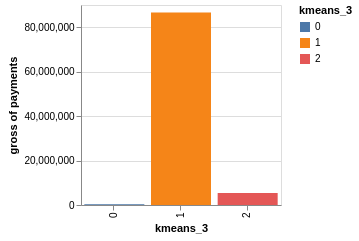

In [192]:
#df_alt = df_uniq_users.groupby(['level_cats','leaving_day']).avg_session_gap_hours.mean().reset_index()
alt.Chart(df_alt).mark_bar(stroke='transparent').encode(
    alt.X('kmeans_3:N', axis=alt.Axis(title='kmeans_3')),
    alt.Y('sum', axis=alt.Axis(title='gross of payments', grid=True)),
    color=alt.Color('kmeans_3:N',title='kmeans_3')
    #tooltip=[alt.Tooltip('is_paid:Q', title='is_paid'),
    #         alt.Tooltip('user_id:Q', title='count of users',format='.2e')]
).properties(
    width=200,
    height=200
)

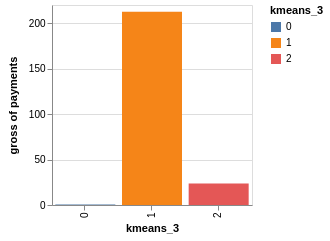

In [193]:
#df_alt = df_uniq_users.groupby(['level_cats','leaving_day']).avg_session_gap_hours.mean().reset_index()
alt.Chart(df_alt).mark_bar(stroke='transparent').encode(
    alt.X('kmeans_3:N', axis=alt.Axis(title='kmeans_3')),
    alt.Y('mean', axis=alt.Axis(title='gross of payments', grid=True)),
    color=alt.Color('kmeans_3:N',title='kmeans_3')
    #tooltip=[alt.Tooltip('is_paid:Q', title='is_paid'),
    #         alt.Tooltip('user_id:Q', title='count of users',format='.2e')]
).properties(
    width=200,
    height=200
)

In [195]:
df_alt = df_X_all.groupby(['kmeans_4']).gross.agg(['sum','mean','median']).reset_index()# .groupby('level_cats').user_id.transform(lambda x: x/x.sum())
#df_alt['relative'] = df_alt.groupby('is_paid').user_id.transform(lambda x: x/x.sum()*100)

In [196]:
df_X_all[['user_id','gross']].head()

user_id   gross
0        1     0.0
1        2   844.0
2        3  1112.0
3        4     0.0
4        5     0.0

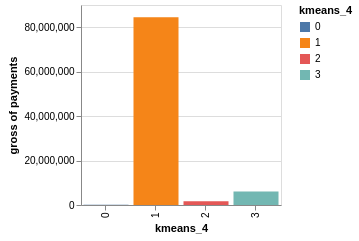

In [197]:
#df_alt = df_uniq_users.groupby(['level_cats','leaving_day']).avg_session_gap_hours.mean().reset_index()
alt.Chart(df_alt).mark_bar(stroke='transparent').encode(
    alt.X('kmeans_4:N', axis=alt.Axis(title='kmeans_4')),
    alt.Y('sum', axis=alt.Axis(title='gross of payments', grid=True)),
    color=alt.Color('kmeans_4:N',title='kmeans_4')
    #tooltip=[alt.Tooltip('is_paid:Q', title='is_paid'),
    #         alt.Tooltip('user_id:Q', title='count of users',format='.2e')]
).properties(
    width=200,
    height=200
)

In [199]:
#df_alt = df_uniq_users.groupby(['level_cats','leaving_day']).avg_session_gap_hours.mean().reset_index()
alt.Chart(df_alt).mark_bar(stroke='transparent').encode(
    alt.X('kmeans_4:N', axis=alt.Axis(title='kmeans_4')),
    alt.Y('median', axis=alt.Axis(title='gross of payments', grid=True)),
    color=alt.Color('kmeans_4:N',title='kmeans_4')
    #tooltip=[alt.Tooltip('is_paid:Q', title='is_paid'),
    #         alt.Tooltip('user_id:Q', title='count of users',format='.2e')]
).properties(
    width=200,
    height=200
)

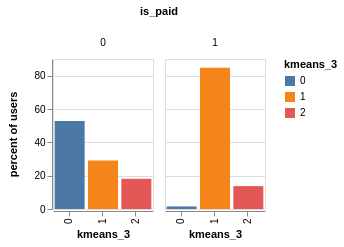

In [186]:
alt.Chart(df_alt).mark_bar(stroke='transparent').encode(
    alt.X('kmeans_3:N', axis=alt.Axis(title='kmeans_3')),
    alt.Y('relative', axis=alt.Axis(title='percent of users', grid=True)),
    color=alt.Color('kmeans_3:N',title='kmeans_3'),
    column='is_paid',
    tooltip=[alt.Tooltip('is_paid:Q', title='is_paid'),
             alt.Tooltip('user_id:Q', title='count of users',format='.2e')]
).properties(
    width=100,
    height=150
)

## Создание категорий на основе leaving_day и сравнение с кластерами:

In [177]:
# Set catigories by leaving_day

bins = [0, 1, 15, 50, np.inf]
labels = ['1 day','15 days','50 days','> 50 days']

df_X_all['leaving_day_cats'] = pd.cut(df_X_all['leaving_day'], bins=bins, labels=labels)

In [178]:
df_alt = df_X_all.groupby(['leaving_day_cats','kmeans_3']).user_id.count().reset_index()# .groupby('level_cats').user_id.transform(lambda x: x/x.sum())
df_alt['relative'] = df_alt.groupby('leaving_day_cats').user_id.transform(lambda x: x/x.sum()*100)

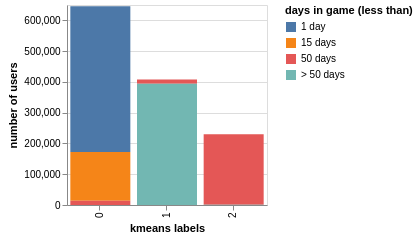

In [179]:
#df_alt = df_uniq_users.groupby(['level_cats','leaving_day']).avg_session_gap_hours.mean().reset_index()
alt.Chart(df_alt).mark_bar(stroke='transparent').encode(
    alt.X('kmeans_3:N', axis=alt.Axis(title='kmeans labels')),
    alt.Y('user_id', axis=alt.Axis(title='number of users', grid=True)),
    color=alt.Color('leaving_day_cats',title='days in game (less than)'),
    tooltip=[alt.Tooltip('leaving_day_cats', title='leaving day'),
             alt.Tooltip('user_id:Q', title='count of users',format='.2e')]
).properties(
    width=200,
    height=200
)

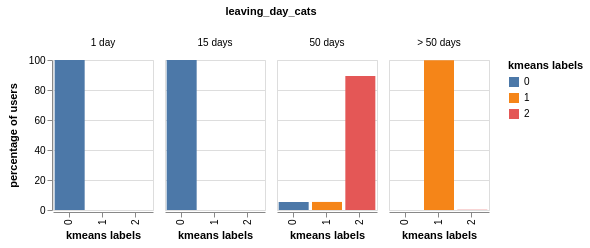

In [168]:
alt.Chart(df_alt).mark_bar(stroke='transparent').encode(
    alt.X('kmeans_3:N', axis=alt.Axis(title='kmeans labels')),
    alt.Y('relative', axis=alt.Axis(title='percentage of users', grid=True)),
    color=alt.Color('kmeans_3:N',title='kmeans labels'),
    column='leaving_day_cats',
    tooltip=[alt.Tooltip('leaving_day:Q', title='leaving day'),
             alt.Tooltip('user_id:Q', title='count of users',format='.2e')]
).properties(
    width=100,
    height=150
)

In [180]:
df_alt = df_X_all.groupby(['leaving_day_cats','kmeans_4']).user_id.count().reset_index()# .groupby('level_cats').user_id.transform(lambda x: x/x.sum())
df_alt['relative'] = df_alt.groupby('leaving_day_cats').user_id.transform(lambda x: x/x.sum()*100)

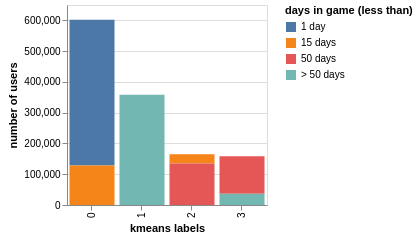

In [181]:
#df_alt = df_uniq_users.groupby(['level_cats','leaving_day']).avg_session_gap_hours.mean().reset_index()
alt.Chart(df_alt).mark_bar(stroke='transparent').encode(
    alt.X('kmeans_4:N', axis=alt.Axis(title='kmeans labels')),
    alt.Y('user_id', axis=alt.Axis(title='number of users', grid=True)),
    color=alt.Color('leaving_day_cats',title='days in game (less than)'),
    tooltip=[alt.Tooltip('leaving_day_cats', title='leaving day'),
             alt.Tooltip('user_id:Q', title='count of users',format='.2e')]
).properties(
    width=200,
    height=200
)

In [175]:
alt.Chart(df_alt).mark_bar(stroke='transparent').encode(
    alt.X('kmeans_4:N', axis=alt.Axis(title='kmeans labels')),
    alt.Y('relative', axis=alt.Axis(title='percentage of users', grid=True)),
    color=alt.Color('kmeans_4:N',title='kmeans labels'),
    column='leaving_day_cats',
    tooltip=[alt.Tooltip('leaving_day:Q', title='leaving day'),
             alt.Tooltip('user_id:Q', title='count of users',format='.2e')]
).properties(
    width=100,
    height=150
)

In [82]:
df_alt = df_X_all.groupby(['leaving_day_cats','kmeans_5']).user_id.count().reset_index()# .groupby('level_cats').user_id.transform(lambda x: x/x.sum())
df_alt['relative'] = df_alt.groupby('leaving_day_cats').user_id.transform(lambda x: x/x.sum()*100)

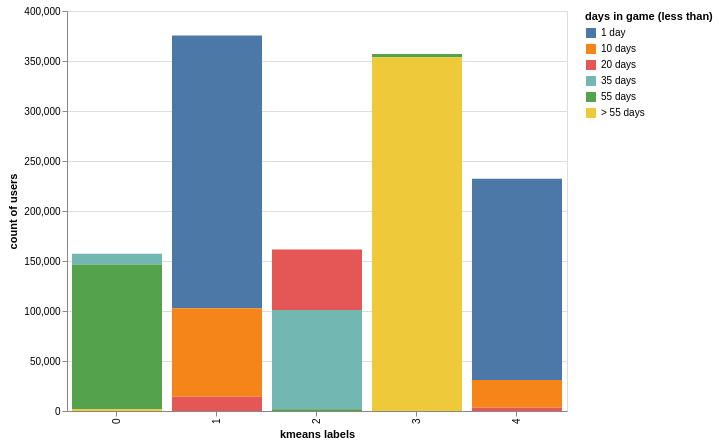

In [83]:
#df_alt = df_uniq_users.groupby(['level_cats','leaving_day']).avg_session_gap_hours.mean().reset_index()
alt.Chart(df_alt).mark_bar(stroke='transparent').encode(
    alt.X('kmeans_5:N', axis=alt.Axis(title='kmeans labels')),
    alt.Y('user_id', axis=alt.Axis(title='count of users', grid=True)),
    color=alt.Color('leaving_day_cats',title='days in game (less than)'),
    tooltip=[alt.Tooltip('leaving_day_cats', title='leaving day'),
             alt.Tooltip('user_id:Q', title='count of users',format='.2e')]
).properties(
    width=500,
    height=400
)

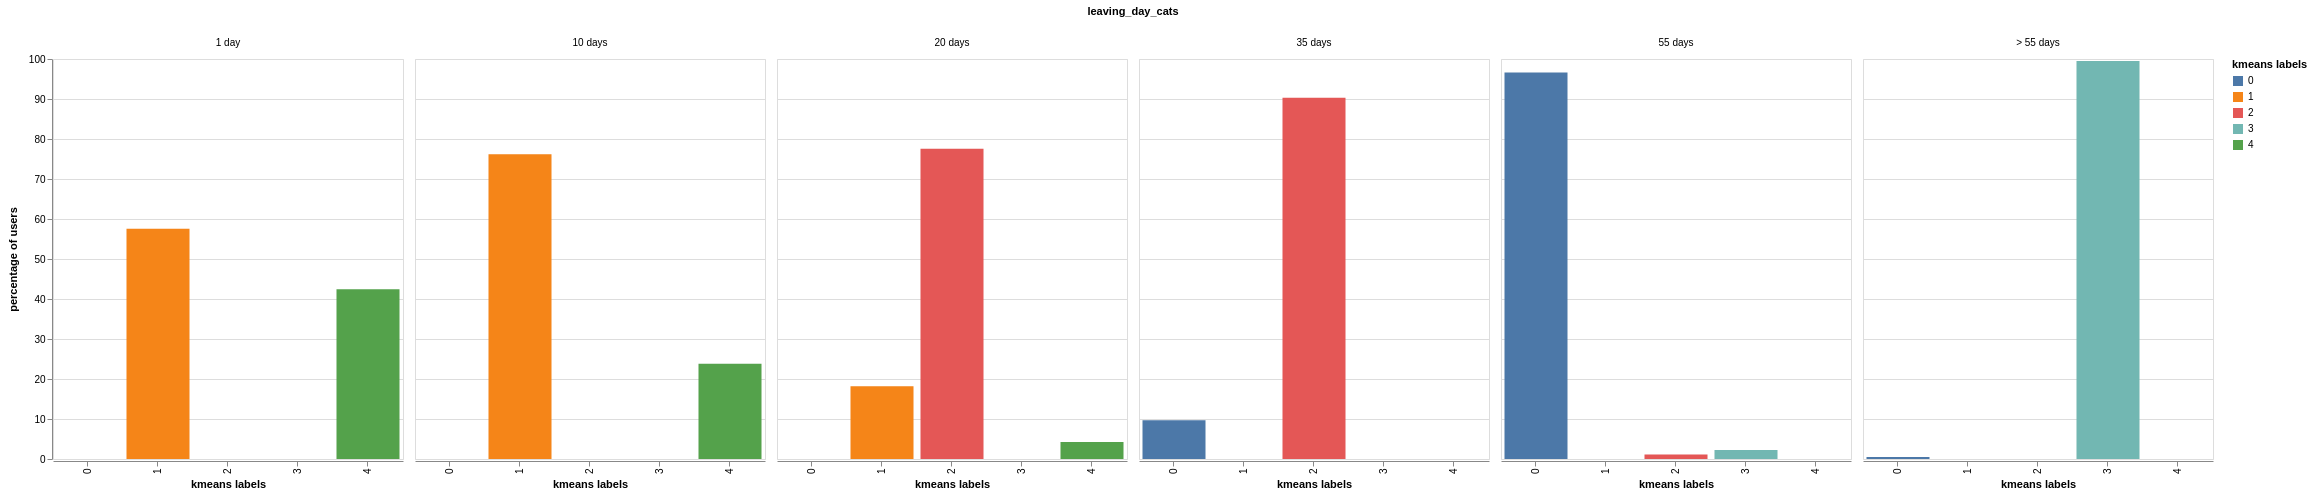

In [84]:
alt.Chart(df_alt).mark_bar(stroke='transparent').encode(
    alt.X('kmeans_5:N', axis=alt.Axis(title='kmeans labels')),
    alt.Y('relative', axis=alt.Axis(title='percentage of users', grid=True)),
    color=alt.Color('kmeans_5:N',title='kmeans labels'),
    column='leaving_day_cats',
    tooltip=[alt.Tooltip('leaving_day:Q', title='leaving day'),
             alt.Tooltip('user_id:Q', title='count of users',format='.2e')]
).properties(
    width=350,
    height=400
)

----------------

----------------------------------

# K-Means without events

In [85]:
df_X_all.head()

user_id  is_old  sex  friends_count  \
0        1       1    1             21   
1        2       1    1            122   
2        3       1    1             35   
3        4       1    1             10   
4        5       1    1             13   

   time_from_install_to_first_session_sec  whole_time_sec  playtime_sec  \
0                                  256157         6570534        383515   
1                                  772578         6213853        156633   
2                                  772652         6209056       2273817   
3                                  349723         6624927        469292   
4                                  819116          432194          2845   

   whole_session_number  avg_session_duration_sec  avg_session_gap_sec  \
0                   183               2095.710383         33994.609890   
1                   533                293.870544         11385.751880   
2                   395               5756.498734          9987.916244   
3                   151               3107.894040         41037.566667   
4                     9                316.111111         53668.625000   

    gross  payment_count  level_min  level_max  level_delta  \
0     0.0              0          1        222          221   
1   844.0              6          1        629          628   
2  1112.0              8          1        584          583   
3     0.0              0          2        399          397   
4     0.0              0          9         59           50   

   level_increase_rate  current_level  is_paid  toys_release_count  \
0             0.000576            222        0                  74   
1             0.004009            629        1                 684   
2             0.000256            588        1                 320   
3             0.000846            399        0                  84   
4             0.017575             65        0                   3   

   toy_purchase_count  gift_count  chest_open_count  is_own_count  \
0                  19           0               385            60   
1                  59           0              1144           194   
2                  80           1              1135           147   
3                  20           0               344            80   
4                   2           0                25             6   

   arcleft_amount_sum  arcright_amount_sum  carousel_amount_sum  \
0                 220                  220                52706   
1                 220                    0               199300   
2                 330                  440               205566   
3                 110                  110                99914   
4                   0                    0                 4400   

   deerhouse_amount_sum  fatherfrost_amount_sum  santahouse_amount_sum  \
0                 27664                    4442                  47231   
1                353513                  205852                 227363   
2                197131                  144404                 225741   
3                103449                   38000                 118110   
4                  1000                    3000                   3129   

   snowmaiden_amount_sum  spruce_amount_sum  arcleft_count  arcright_count  \
0                  43000              49948              5               3   
1                 302222             301373              2               0   
2                 298053             291992              6               4   
3                 155341             147370              2               2   
4                      0                126              0               0   

   carousel_count  deerhouse_count  fatherfrost_count  santahouse_count  \
0              94               73                 13                91   
1              58              137                108                69   
2             152              111                 69               153   
3              54     

In [86]:
main_columns = ['is_old','friends_count','time_from_install_to_first_session_sec','whole_time_sec','playtime_sec','whole_session_number','avg_session_duration_sec',
                'avg_session_gap_sec','gross','payment_count','level_min','level_max','level_delta','level_increase_rate','is_paid','current_level']

In [87]:
len(main_columns)

16

## Расчет инерции для оценки возможного числа кластеров

In [88]:
%%time

from sklearn.cluster import KMeans

#n_comp = 16
class_range = 11
#X_prepca = PCA(n_components=n_comp).fit_transform(X)

inertia = []
for k in range(1, class_range):
    kmeans = KMeans(n_clusters=k, random_state=17, n_jobs=-1).fit(df_X_all[main_columns])
    inertia.append(np.sqrt(kmeans.inertia_))

plt.plot(range(1, class_range), inertia, marker='s');
plt.xlabel('$k$')
plt.ylabel('$J(C_k)$');

CPU times: user 12min 19s, sys: 9.03 s, total: 12min 28s
Wall time: 3min 7s


## Model 

In [89]:
#kmeans_reduced = KMeans(n_clusters=6, random_state=17, n_jobs=-1).fit(df_X_all[main_columns])
# Доп. настройки:
kmeans_reduced_3 = KMeans(n_clusters=3, random_state=17, n_jobs=-1).fit(df_X_all[main_columns])
kmeans_reduced_4 = KMeans(n_clusters=4, random_state=17, n_jobs=-1).fit(df_X_all[main_columns])
kmeans_reduced_5 = KMeans(n_clusters=5, random_state=17, n_jobs=-1).fit(df_X_all[main_columns])

In [90]:
df_X_all['kmeans_reduced_3'] = kmeans_reduced_3.labels_
df_X_all['kmeans_reduced_4'] = kmeans_reduced_4.labels_
df_X_all['kmeans_reduced_5'] = kmeans_reduced_5.labels_

In [141]:
df_X_all.groupby('kmeans_reduced_3').user_id.count()

kmeans_reduced_3
0    409585
1    645447
2    228458
Name: user_id, dtype: int64

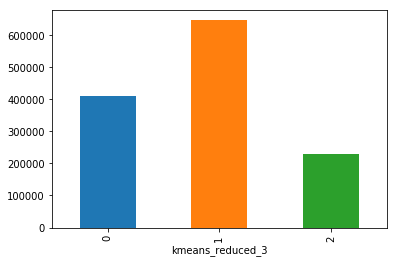

In [142]:
df_X_all.groupby('kmeans_reduced_3').user_id.count().plot.bar()

## Сопоставление с level_cats:

In [143]:
df_alt = df_X_all.groupby(['level_cats','kmeans_reduced_3']).user_id.count().reset_index()# .groupby('level_cats').user_id.transform(lambda x: x/x.sum())
df_alt['relative'] = df_alt.groupby('level_cats').user_id.transform(lambda x: x/x.sum()*100)

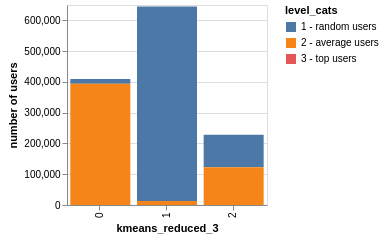

In [145]:
#df_alt = df_uniq_users.groupby(['level_cats','leaving_day']).avg_session_gap_hours.mean().reset_index()
alt.Chart(df_alt).mark_bar(stroke='transparent').encode(
    alt.X('kmeans_reduced_3:N', axis=alt.Axis(title='kmeans_reduced_3')),
    alt.Y('user_id', axis=alt.Axis(title='number of users', grid=True)),
    color=alt.Color('level_cats:N',title='level_cats'),
    tooltip=[alt.Tooltip('level_cats:N', title='level_cats'),
             alt.Tooltip('user_id:Q', title='count of users',format='.2e')]
).properties(
    width=200,
    height=200
)

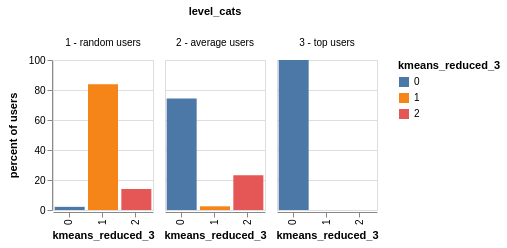

In [146]:
alt.Chart(df_alt).mark_bar(stroke='transparent').encode(
    alt.X('kmeans_reduced_3:N', axis=alt.Axis(title='kmeans_reduced_3')),
    alt.Y('relative', axis=alt.Axis(title='percent of users', grid=True)),
    color=alt.Color('kmeans_reduced_3:N',title='kmeans_reduced_3'),
    column='level_cats',
    tooltip=[alt.Tooltip('level_cats:N', title='level_cats'),
             alt.Tooltip('user_id:Q', title='count of users',format='.2e')]
).properties(
    width=100,
    height=150
)

In [94]:
df_alt = df_X_all.groupby(['level_cats','kmeans_reduced_4']).user_id.count().reset_index()# .groupby('level_cats').user_id.transform(lambda x: x/x.sum())
df_alt['relative'] = df_alt.groupby('level_cats').user_id.transform(lambda x: x/x.sum()*100)

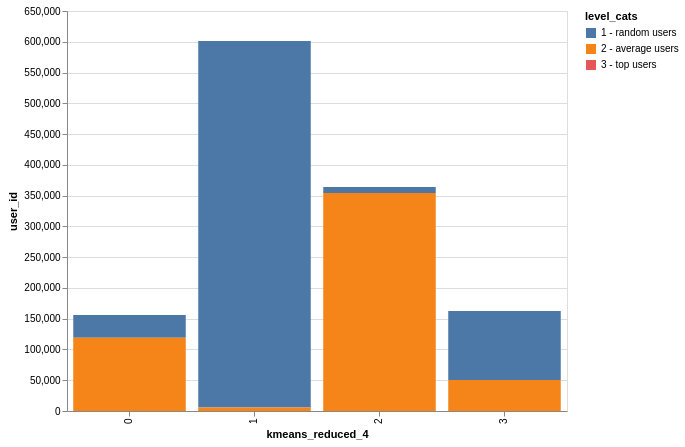

In [95]:
#df_alt = df_uniq_users.groupby(['level_cats','leaving_day']).avg_session_gap_hours.mean().reset_index()
alt.Chart(df_alt).mark_bar(stroke='transparent').encode(
    alt.X('kmeans_reduced_4:N', axis=alt.Axis(title='kmeans_reduced_4')),
    alt.Y('user_id', axis=alt.Axis(title='user_id', grid=True)),
    color=alt.Color('level_cats:N',title='level_cats'),
    tooltip=[alt.Tooltip('level_cats:N', title='level_cats'),
             alt.Tooltip('user_id:Q', title='count of users',format='.2e')]
).properties(
    width=500,
    height=400
)

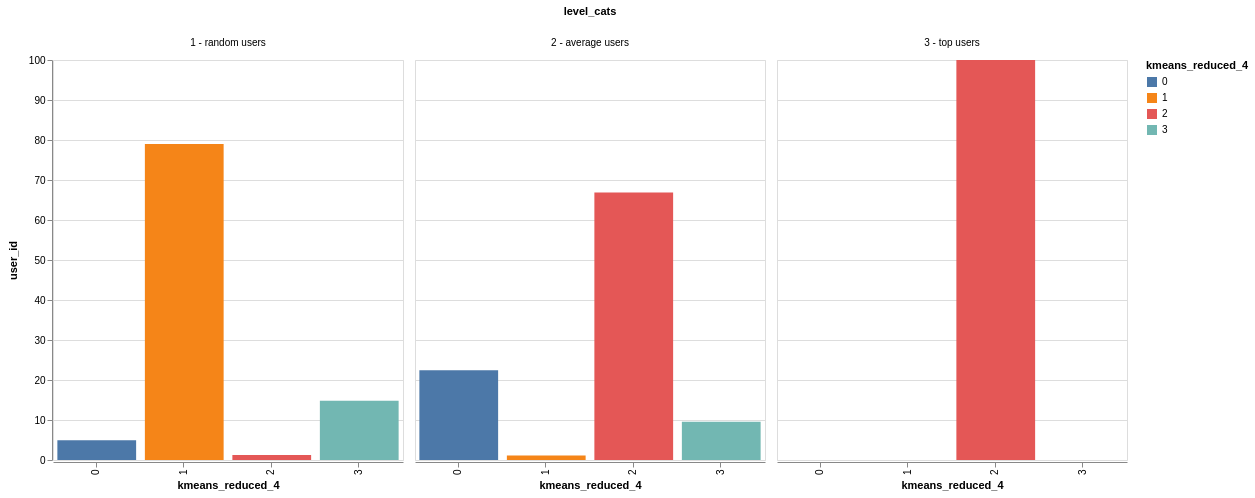

In [96]:
alt.Chart(df_alt).mark_bar(stroke='transparent').encode(
    alt.X('kmeans_reduced_4:N', axis=alt.Axis(title='kmeans_reduced_4')),
    alt.Y('relative', axis=alt.Axis(title='user_id', grid=True)),
    color=alt.Color('kmeans_reduced_4:N',title='kmeans_reduced_4'),
    column='level_cats',
    tooltip=[alt.Tooltip('level_cats:N', title='level_cats'),
             alt.Tooltip('user_id:Q', title='count of users',format='.2e')]
).properties(
    width=350,
    height=400
)

In [97]:
df_alt = df_X_all.groupby(['level_cats','kmeans_reduced_5']).user_id.count().reset_index()# .groupby('level_cats').user_id.transform(lambda x: x/x.sum())
df_alt['relative'] = df_alt.groupby('level_cats').user_id.transform(lambda x: x/x.sum()*100)

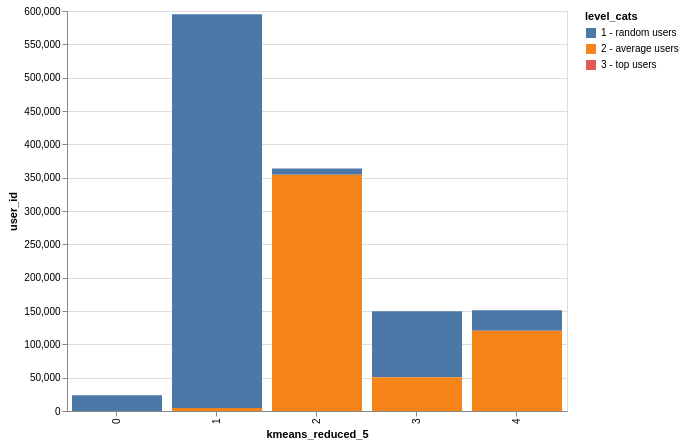

In [98]:
#df_alt = df_uniq_users.groupby(['level_cats','leaving_day']).avg_session_gap_hours.mean().reset_index()
alt.Chart(df_alt).mark_bar(stroke='transparent').encode(
    alt.X('kmeans_reduced_5:N', axis=alt.Axis(title='kmeans_reduced_5')),
    alt.Y('user_id', axis=alt.Axis(title='user_id', grid=True)),
    color=alt.Color('level_cats:N',title='level_cats'),
    tooltip=[alt.Tooltip('level_cats:N', title='level_cats'),
             alt.Tooltip('user_id:Q', title='count of users',format='.2e')]
).properties(
    width=500,
    height=400
)

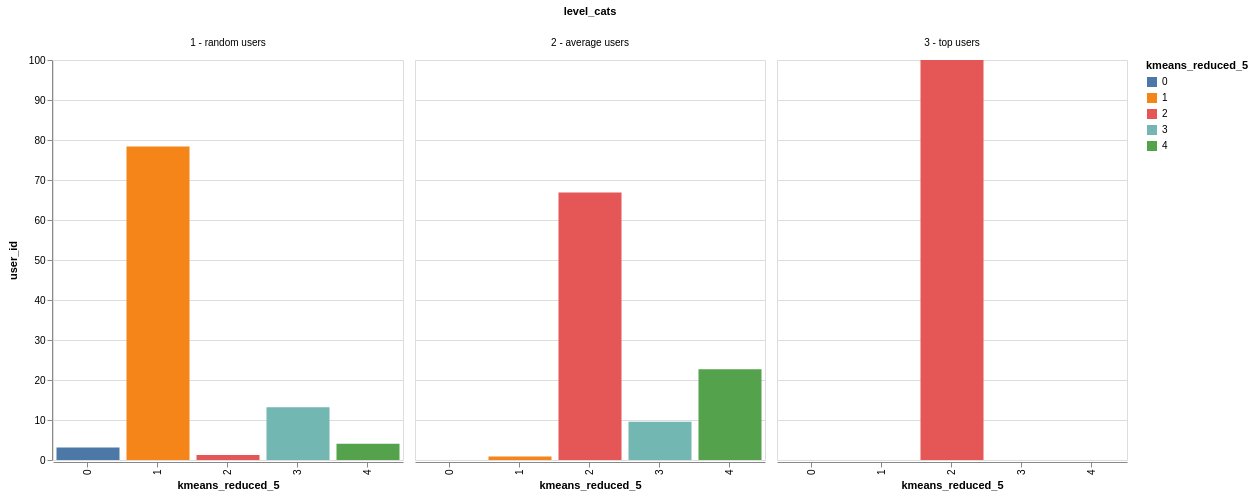

In [99]:
alt.Chart(df_alt).mark_bar(stroke='transparent').encode(
    alt.X('kmeans_reduced_5:N', axis=alt.Axis(title='kmeans_reduced_5')),
    alt.Y('relative', axis=alt.Axis(title='user_id', grid=True)),
    color=alt.Color('kmeans_reduced_5:N',title='kmeans_reduced_5'),
    column='level_cats',
    tooltip=[alt.Tooltip('level_cats:N', title='level_cats'),
             alt.Tooltip('user_id:Q', title='count of users',format='.2e')]
).properties(
    width=350,
    height=400
)

## Сопоставление с полной моделью:

In [129]:
df_alt = df_X_all.groupby(['kmeans_3','kmeans_reduced_3']).user_id.count().reset_index()# .groupby('level_cats').user_id.transform(lambda x: x/x.sum())
df_alt['relative'] = df_alt.groupby('kmeans_3').user_id.transform(lambda x: x/x.sum()*100)

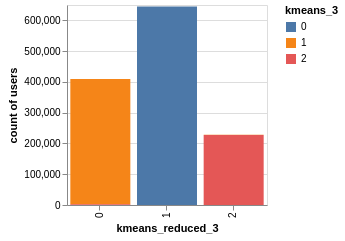

In [132]:
#df_alt = df_uniq_users.groupby(['level_cats','leaving_day']).avg_session_gap_hours.mean().reset_index()
alt.Chart(df_alt).mark_bar(stroke='transparent').encode(
    alt.X('kmeans_reduced_3:N', axis=alt.Axis(title='kmeans_reduced_3')),
    alt.Y('user_id', axis=alt.Axis(title='count of users', grid=True)),
    color=alt.Color('kmeans_3:N',title='kmeans_3'),
    tooltip=[alt.Tooltip('kmeans_3:N', title='kmeans_3'),
             alt.Tooltip('user_id:Q', title='count of users',format='.2e')]
).properties(
    width=200,
    height=200
)

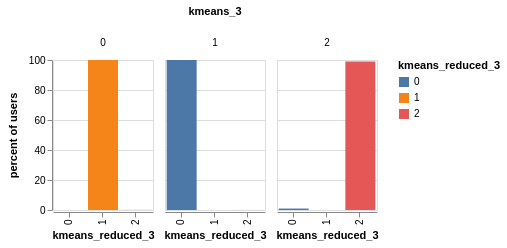

In [135]:
alt.Chart(df_alt).mark_bar(stroke='transparent').encode(
    alt.X('kmeans_reduced_3:N', axis=alt.Axis(title='kmeans_reduced_3')),
    alt.Y('relative', axis=alt.Axis(title='percent of users', grid=True)),
    color=alt.Color('kmeans_reduced_3:N',title='kmeans_reduced_3'),
    column='kmeans_3',
    tooltip=[alt.Tooltip('kmeans_3:N', title='kmeans_3'),
             alt.Tooltip('user_id:Q', title='count of users',format='.2e')]
).properties(
    width=100,
    height=150
)

In [136]:
df_alt = df_X_all.groupby(['kmeans_4','kmeans_reduced_4']).user_id.count().reset_index()# .groupby('level_cats').user_id.transform(lambda x: x/x.sum())
df_alt['relative'] = df_alt.groupby('kmeans_4').user_id.transform(lambda x: x/x.sum()*100)

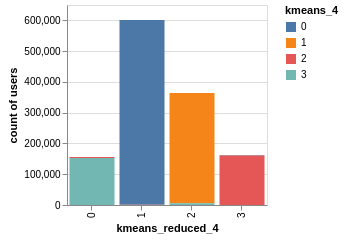

In [138]:
#df_alt = df_uniq_users.groupby(['level_cats','leaving_day']).avg_session_gap_hours.mean().reset_index()
alt.Chart(df_alt).mark_bar(stroke='transparent').encode(
    alt.X('kmeans_reduced_4:N', axis=alt.Axis(title='kmeans_reduced_4')),
    alt.Y('user_id', axis=alt.Axis(title='count of users', grid=True)),
    color=alt.Color('kmeans_4:N',title='kmeans_4'),
    tooltip=[alt.Tooltip('kmeans_4:N', title='kmeans_4'),
             alt.Tooltip('user_id:Q', title='count of users',format='.2e')]
).properties(
    width=200,
    height=200
)

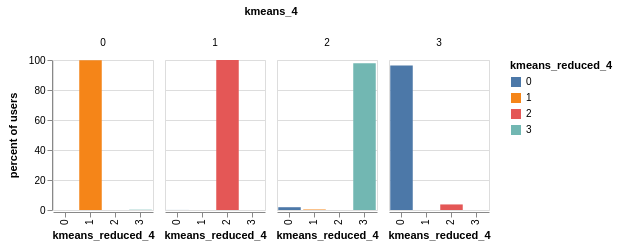

In [140]:
alt.Chart(df_alt).mark_bar(stroke='transparent').encode(
    alt.X('kmeans_reduced_4:N', axis=alt.Axis(title='kmeans_reduced_4')),
    alt.Y('relative', axis=alt.Axis(title='percent of users', grid=True)),
    color=alt.Color('kmeans_reduced_4:N',title='kmeans_reduced_4'),
    column='kmeans_4',
    tooltip=[alt.Tooltip('kmeans_4:N', title='kmeans_4'),
             alt.Tooltip('user_id:Q', title='count of users',format='.2e')]
).properties(
    width=100,
    height=150
)

In [108]:
df_alt = df_X_all.groupby(['kmeans_5','kmeans_reduced_5']).user_id.count().reset_index()# .groupby('level_cats').user_id.transform(lambda x: x/x.sum())
df_alt['relative'] = df_alt.groupby('kmeans_5').user_id.transform(lambda x: x/x.sum()*100)

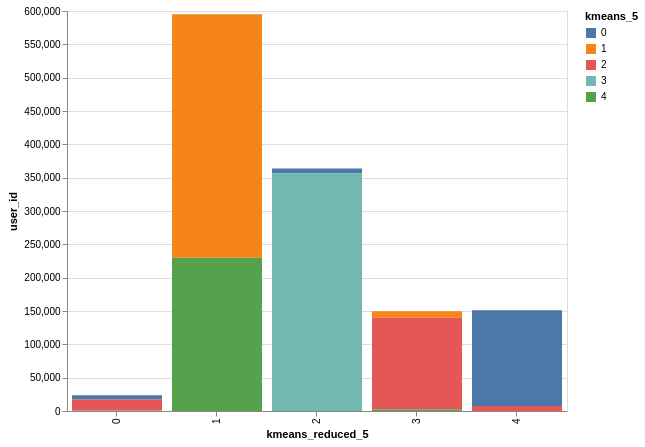

In [109]:
#df_alt = df_uniq_users.groupby(['level_cats','leaving_day']).avg_session_gap_hours.mean().reset_index()
alt.Chart(df_alt).mark_bar(stroke='transparent').encode(
    alt.X('kmeans_reduced_5:N', axis=alt.Axis(title='kmeans_reduced_5')),
    alt.Y('user_id', axis=alt.Axis(title='user_id', grid=True)),
    color=alt.Color('kmeans_5:N',title='kmeans_5'),
    tooltip=[alt.Tooltip('kmeans_5:N', title='kmeans_5'),
             alt.Tooltip('user_id:Q', title='count of users',format='.2e')]
).properties(
    width=500,
    height=400
)

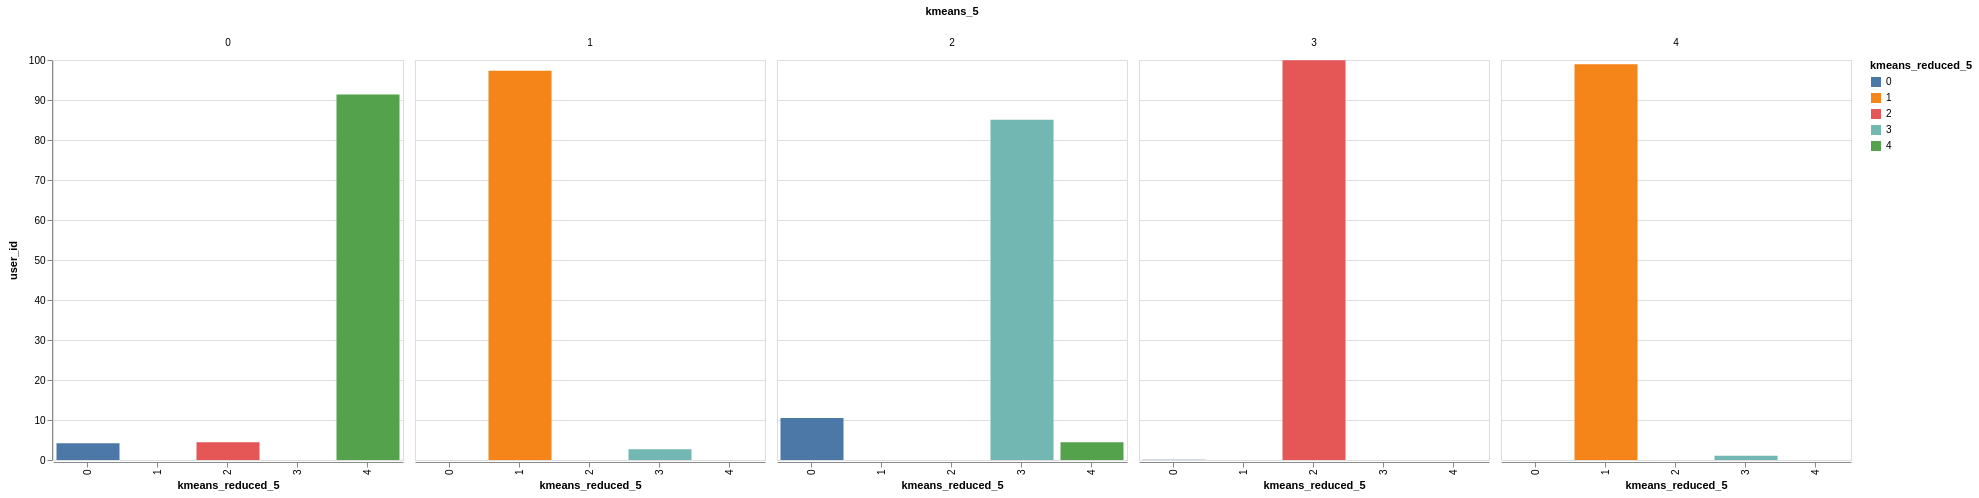

In [110]:
alt.Chart(df_alt).mark_bar(stroke='transparent').encode(
    alt.X('kmeans_reduced_5:N', axis=alt.Axis(title='kmeans_reduced_5')),
    alt.Y('relative', axis=alt.Axis(title='user_id', grid=True)),
    color=alt.Color('kmeans_reduced_5:N',title='kmeans_reduced_5'),
    column='kmeans_5',
    tooltip=[alt.Tooltip('kmeans_5:N', title='kmeans_5'),
             alt.Tooltip('user_id:Q', title='count of users',format='.2e')]
).properties(
    width=350,
    height=400
)

---------------

# Whole time

## wasted_hours_cats 

In [148]:
df_alt = df_X_all.groupby(['wasted_hours_cats','kmeans_reduced_3']).user_id.count().reset_index()# .groupby('level_cats').user_id.transform(lambda x: x/x.sum())
df_alt['relative'] = df_alt.groupby('wasted_hours_cats').user_id.transform(lambda x: x/x.sum()*100)

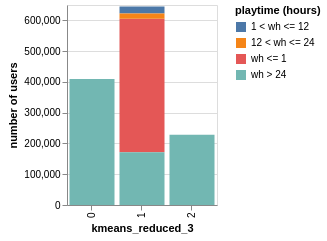

In [156]:
#df_alt = df_uniq_users.groupby(['level_cats','leaving_day']).avg_session_gap_hours.mean().reset_index()
alt.Chart(df_alt).mark_bar(stroke='transparent').encode(
    alt.X('kmeans_reduced_3:N', axis=alt.Axis(title='kmeans_reduced_3')),
    alt.Y('user_id', axis=alt.Axis(title='number of users', grid=True)),
    color=alt.Color('wasted_hours_cats:N',title='playtime (hours)'),
    tooltip=[alt.Tooltip('wasted_hours_cats:N', title='wasted_hours_cats'),
             alt.Tooltip('user_id:Q', title='count of users',format='.2e')]
).properties(
    width=150,
    height=200
)

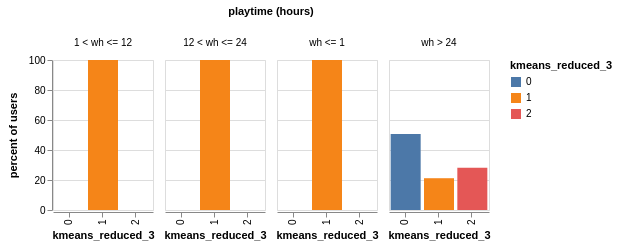

In [161]:
alt.Chart(df_alt).mark_bar(stroke='transparent').encode(
    alt.X('kmeans_reduced_3:N', axis=alt.Axis(title='kmeans_reduced_3')),
    alt.Y('relative', axis=alt.Axis(title='percent of users', grid=True)),
    color=alt.Color('kmeans_reduced_3:N',title='kmeans_reduced_3'),
    column=alt.Column('wasted_hours_cats',title='playtime (hours)'),
    tooltip=[alt.Tooltip('wasted_hours_cats:N', title='wasted_hours_cats'),
             alt.Tooltip('user_id:Q', title='count of users',format='.2e')]
).properties(
    width=100,
    height=150
)

In [123]:
df_alt = df_X_all.groupby(['wasted_hours_cats','kmeans_reduced_4']).user_id.count().reset_index()# .groupby('level_cats').user_id.transform(lambda x: x/x.sum())
df_alt['relative'] = df_alt.groupby('wasted_hours_cats').user_id.transform(lambda x: x/x.sum()*100)

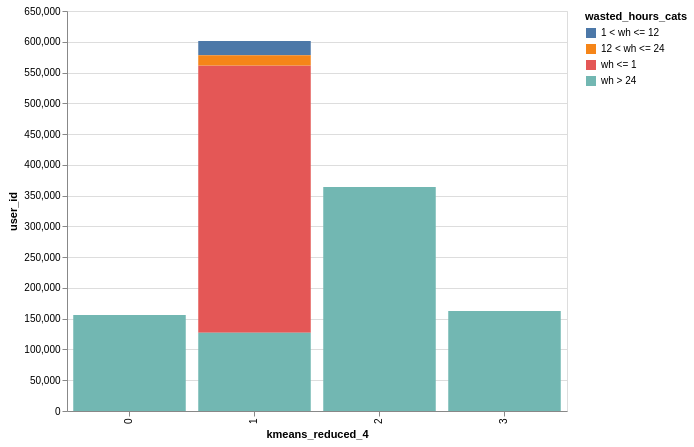

In [124]:
#df_alt = df_uniq_users.groupby(['level_cats','leaving_day']).avg_session_gap_hours.mean().reset_index()
alt.Chart(df_alt).mark_bar(stroke='transparent').encode(
    alt.X('kmeans_reduced_4:N', axis=alt.Axis(title='kmeans_reduced_4')),
    alt.Y('user_id', axis=alt.Axis(title='user_id', grid=True)),
    color=alt.Color('wasted_hours_cats:N',title='wasted_hours_cats'),
    tooltip=[alt.Tooltip('wasted_hours_cats:N', title='wasted_hours_cats'),
             alt.Tooltip('user_id:Q', title='count of users',format='.2e')]
).properties(
    width=500,
    height=400
)

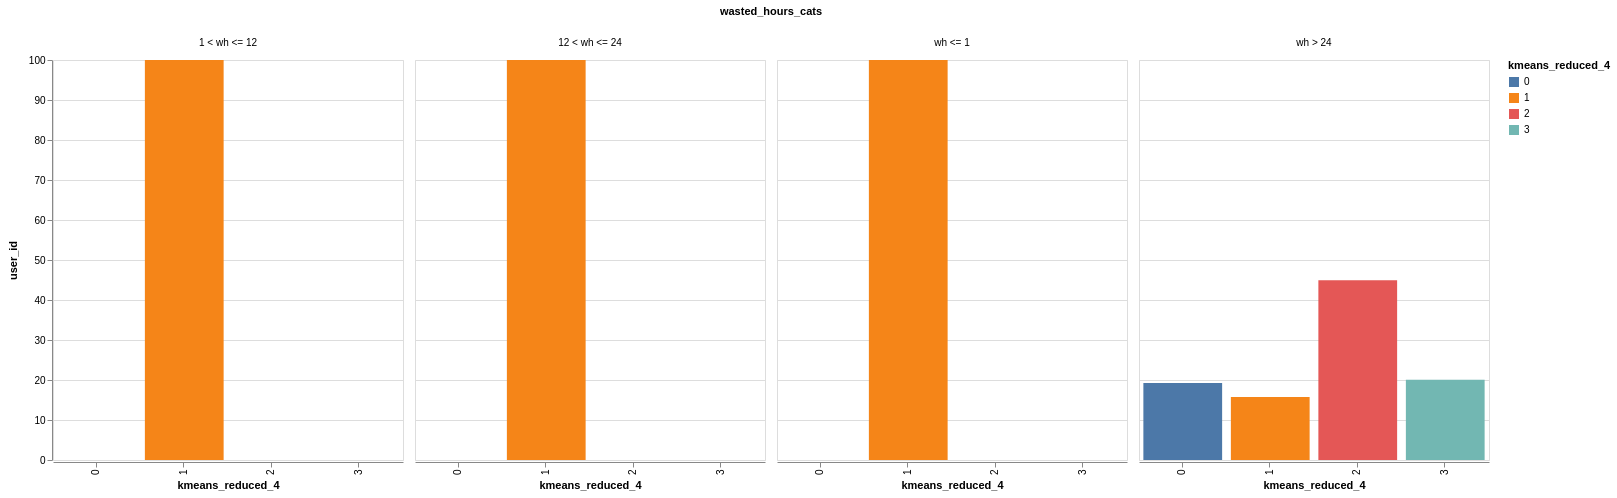

In [125]:
alt.Chart(df_alt).mark_bar(stroke='transparent').encode(
    alt.X('kmeans_reduced_4:N', axis=alt.Axis(title='kmeans_reduced_4')),
    alt.Y('relative', axis=alt.Axis(title='user_id', grid=True)),
    color=alt.Color('kmeans_reduced_4:N',title='kmeans_reduced_4'),
    column='wasted_hours_cats',
    tooltip=[alt.Tooltip('wasted_hours_cats:N', title='wasted_hours_cats'),
             alt.Tooltip('user_id:Q', title='count of users',format='.2e')]
).properties(
    width=350,
    height=400
)

In [126]:
df_alt = df_X_all.groupby(['wasted_hours_cats','kmeans_reduced_5']).user_id.count().reset_index()# .groupby('level_cats').user_id.transform(lambda x: x/x.sum())
df_alt['relative'] = df_alt.groupby('wasted_hours_cats').user_id.transform(lambda x: x/x.sum()*100)

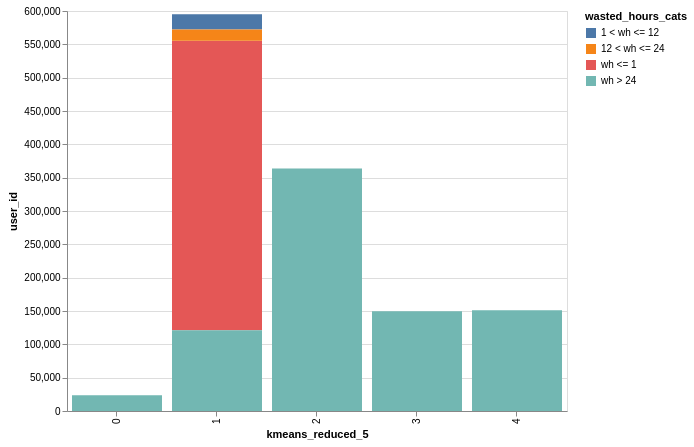

In [127]:
#df_alt = df_uniq_users.groupby(['level_cats','leaving_day']).avg_session_gap_hours.mean().reset_index()
alt.Chart(df_alt).mark_bar(stroke='transparent').encode(
    alt.X('kmeans_reduced_5:N', axis=alt.Axis(title='kmeans_reduced_5')),
    alt.Y('user_id', axis=alt.Axis(title='user_id', grid=True)),
    color=alt.Color('wasted_hours_cats:N',title='wasted_hours_cats'),
    tooltip=[alt.Tooltip('wasted_hours_cats:N', title='wasted_hours_cats'),
             alt.Tooltip('user_id:Q', title='count of users',format='.2e')]
).properties(
    width=500,
    height=400
)

In [128]:
alt.Chart(df_alt).mark_bar(stroke='transparent').encode(
    alt.X('kmeans_reduced_5:N', axis=alt.Axis(title='kmeans_reduced_5')),
    alt.Y('relative', axis=alt.Axis(title='user_id', grid=True)),
    color=alt.Color('kmeans_reduced_5:N',title='kmeans_reduced_5'),
    column='wasted_hours_cats',
    tooltip=[alt.Tooltip('wasted_hours_cats:N', title='wasted_hours_cats'),
             alt.Tooltip('user_id:Q', title='count of users',format='.2e')]
).properties(
    width=350,
    height=400
)